In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.19.0


In [ ]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv('dipole_dataset.csv')
print(f"Dataset shape: {df.shape}")
# print(f"Antenna types: {df['antenna_type'].value_counts().to_dict()}")
df.head()



Loading dataset...
Dataset shape: (3062, 371)


,sample_id,frequency_ghz,wavelength_m,length_m,length_wl,width_m,width_wl,max_gain_dbi,min_gain_dbi,avg_gain_dbi,...,gain_350deg,gain_351deg,gain_352deg,gain_353deg,gain_354deg,gain_355deg,gain_356deg,gain_357deg,gain_358deg,gain_359deg
0,3,1.051945,0.284989,0.343993,1.207043,0.002730,0.009579,4.895439,-46.313187,-6.012472,...,3.870455,4.068042,4.243674,4.397753,4.530625,4.642581,4.733862,4.804662,4.855128,4.885366
1,4,2.905199,0.103192,0.054261,0.525823,0.001002,0.009709,2.204796,-50.122984,-5.095898,...,1.996503,2.036081,2.071491,2.102735,2.129813,2.152724,2.171470,2.186050,2.196465,2.202713
2,5,2.884351,0.103938,0.114270,1.099407,0.000834,0.008023,4.476284,-52.599360,-9.076045,...,3.742702,3.882942,4.008073,4.118213,4.213466,4.293920,4.359648,4.410710,4.447150,4.469002
3,6,0.683093,0.438875,0.433645,0.988082,0.004023,0.009166,3.865736,-57.217940,-10.823129,...,3.321123,3.424775,3.517446,3.599160,3.669938,3.729797,3.778752,3.816815,3.843996,3.860302
4,7,2.438960,0.122918,0.237123,1.929112,0.000810,0.006592,3.840164,-56.599911,-7.725011,...,-8.394547,-9.859518,-11.466459,-13.219070,-15.105154,-17.077469,-19.024249,-20.750640,-22.033979,-22.765219


In [ ]:
# ========== DATA PREPROCESSING ==========

# Fill NaN values with 0 (for parameters that don't apply to all types)
df = df.fillna(0)

# Separate features and target
# Input features: Focus on dipole and monopole relevant parameters
feature_cols = ['frequency_ghz', 'length_wl', 'width_wl']

# Target: gain at all 360 angles
target_cols = [f'gain_{i}deg' for i in range(360)]

# Encode antenna type as one-hot (only 2 types now: dipole, monopole)
encoder = LabelEncoder()
# df['antenna_type_encoded'] = encoder.fit_transform(df['antenna_type'])

# Create one-hot encoding
# antenna_dummies = pd.get_dummies(df['antenna_type'], prefix='type')
# df = pd.concat([df, antenna_dummies], axis=1)

# Final feature columns
feature_cols_final = feature_cols

X = df[feature_cols_final].values
y = df[target_cols].values

print(f"\nFeature shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features used: {feature_cols_final}")

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)




Feature shape: (3062, 3)
Target shape: (3062, 360)
Features used: ['frequency_ghz', 'length_wl', 'width_wl']

Train set: 2296 samples
Validation set: 459 samples
Test set: 307 samples


In [ ]:
# ========== BUILD NEURAL NETWORK ==========

print("\n" + "="*50)
print("Building Neural Network Model...")
print("="*50)

model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),

    # Hidden layers - deeper network for 2800 samples
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(128, activation='relu'),

    # Output layer: 360 gain values
    layers.Dense(360, activation='linear')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

# ========== TRAIN MODEL ==========

print("\n" + "="*50)
print("Training Model...")
print("="*50)

# Callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-7,
    verbose=1
)

# Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ========== EVALUATE MODEL ==========

print("\n" + "="*50)
print("Evaluating Model on Test Set...")
print("="*50)

# Predict on test set
y_pred = model.predict(X_test_scaled)




Building Neural Network Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 360)            │        46,440 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,096 (2.46 MB)

 Trainable params: 641,768 (2.45 MB)

 Non-trainable params: 3,328 (13.00 KB)


Training Model...
Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 102.1457 - mae: 6.4283 - val_loss: 25.2618 - val_mae: 3.3109 - learning_rate: 0.0010
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9751 - mae: 2.4527 - val_loss: 24.3079 - val_mae: 3.4995 - learning_rate: 0.0010
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.4424 - mae: 2.0649 - val_loss: 21.3177 - val_mae: 2.8671 - learning_rate: 0.0010
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6287 - mae: 1.9868 - val_loss: 12.5769 - val_mae: 2.1754 - learning_rate: 0.0010
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.6083 - mae: 1.8932 - val_loss: 5.7933 - val_mae: 1.5275 - learning_rate: 0.0010
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8779 - mae: 1.6740 - val_loss: 3.6466 - val_mae: 1.1741 - learning_rate: 0.0010
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2791 - mae: 1.7219 - val_loss: 2.4675 - val_mae: 0.9444 - learni

In [ ]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.4f} dB")
print(f"  R² Score: {r2:.4f}")

# Per-antenna-type evaluation
print(f"\nPerformance by Antenna Type:")
test_indices = X_temp.shape[0] - X_test.shape[0]
test_df = df.iloc[-X_test.shape[0]:]






Test Set Performance:
  Mean Squared Error (MSE): 0.1480
  Mean Absolute Error (MAE): 0.2080 dB
  R² Score: 0.9957

Performance by Antenna Type:


In [ ]:

type_mae = mean_absolute_error(y_test, y_pred)
type_r2 = r2_score(y_test, y_pred)
print(f"  'DIPOLE': MAE = {type_mae:.3f} dB, R² = {type_r2:.4f}")

  'DIPOLE': MAE = 0.208 dB, R² = 0.9957


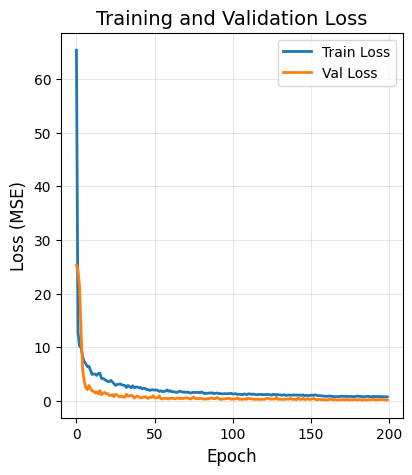

In [ ]:
# ========== VISUALIZATION ==========

# Plot 1: Training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)





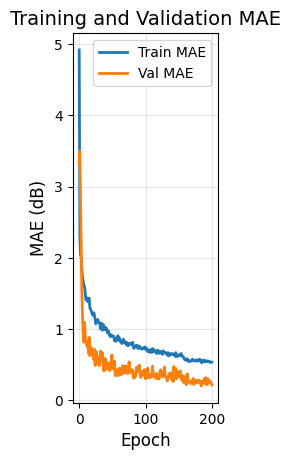

In [ ]:
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE (dB)', fontsize=12)
plt.title('Training and Validation MAE', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)


✅ Training plots saved as 'training_results.png'


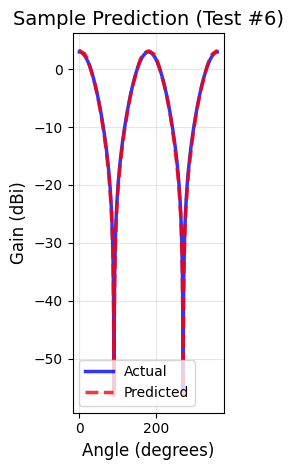

In [ ]:
# Plot 3: Sample prediction vs actual
sample_idx = np.random.randint(0, len(y_test))
plt.subplot(1, 3, 3)
angles = np.arange(360)
plt.plot(angles, y_test[sample_idx], 'b-', label='Actual', linewidth=2.5, alpha=0.8)
plt.plot(angles, y_pred[sample_idx], 'r--', label='Predicted', linewidth=2.5, alpha=0.8)
plt.xlabel('Angle (degrees)', fontsize=12)
plt.ylabel('Gain (dBi)', fontsize=12)
plt.title(f'Sample Prediction (Test #{sample_idx})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Training plots saved as 'training_results.png'")



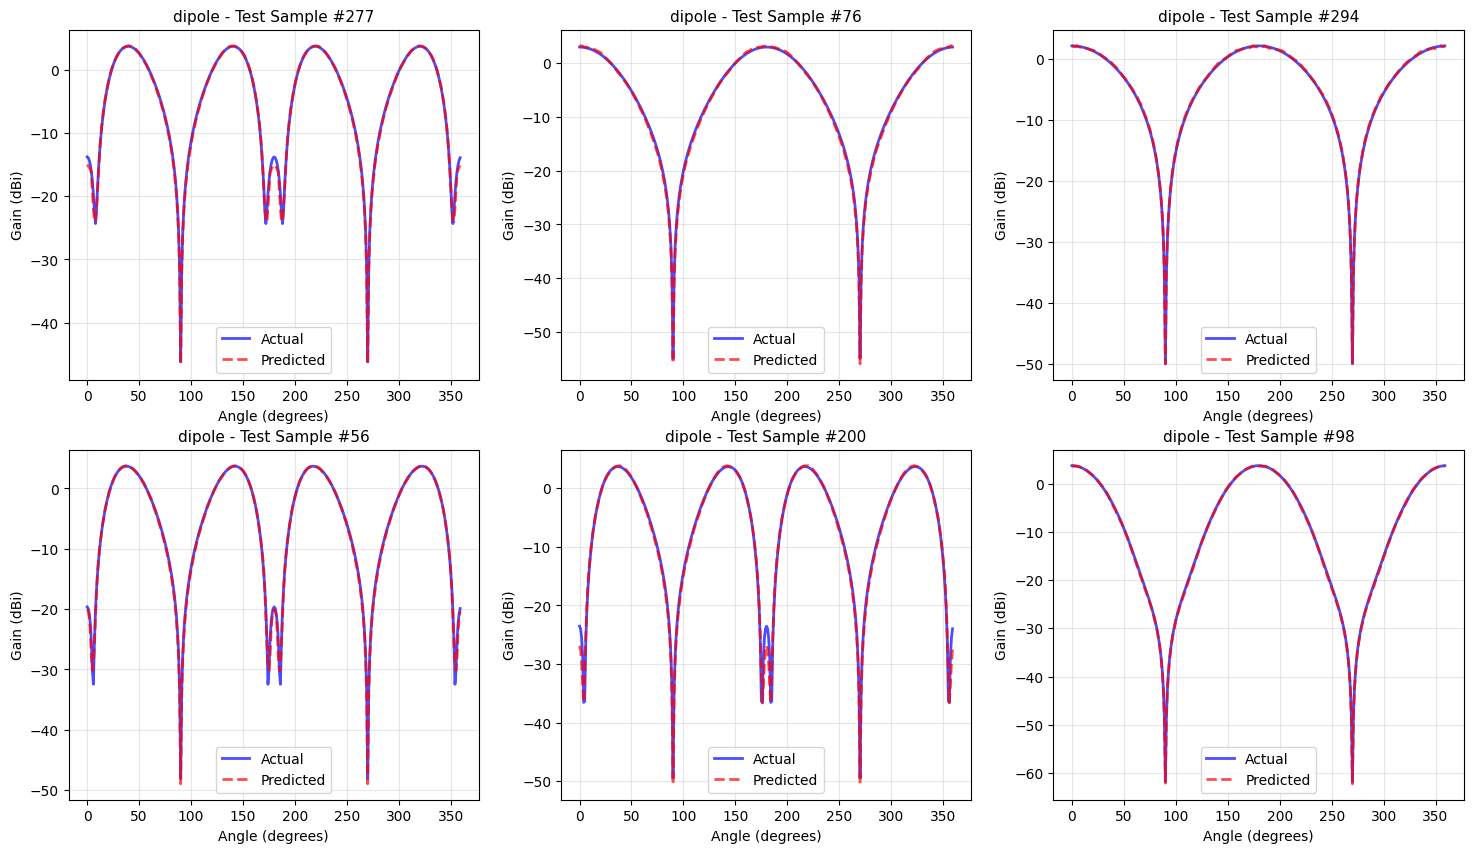

In [ ]:
# Plot 2: Multiple sample comparisons - separate by antenna type
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i in range(6):
    sample_idx = np.random.randint(0, len(y_test))
    ax = axes[i//3, i%3]

    # Get antenna type for this sample
    # ant_type = test_df.iloc[sample_idx]['antenna_type']

    ax.plot(angles, y_test[sample_idx], 'b-', label='Actual', linewidth=2, alpha=0.7)
    ax.plot(angles, y_pred[sample_idx], 'r--', label='Predicted', linewidth=2, alpha=0.7)
    ax.set_xlabel('Angle (degrees)', fontsize=10)
    ax.set_ylabel('Gain (dBi)', fontsize=10)
    ax.set_title(f'dipole - Test Sample #{sample_idx}', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)



✅ Sample predictions saved as 'sample_predictions.png'
✅ Error analysis saved as 'error_analysis.png'


<Figure size 640x480 with 0 Axes>

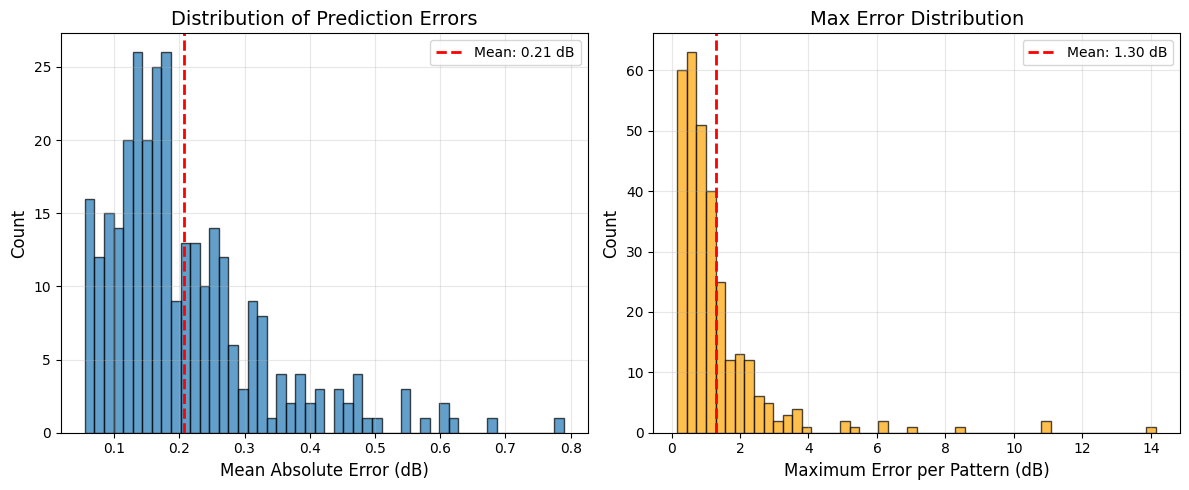

In [ ]:
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
print("✅ Sample predictions saved as 'sample_predictions.png'")

# Plot 3: Error distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
errors = np.abs(y_test - y_pred)
mean_errors_per_sample = np.mean(errors, axis=1)
plt.hist(mean_errors_per_sample, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Mean Absolute Error (dB)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14)
plt.axvline(np.mean(mean_errors_per_sample), color='r', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(mean_errors_per_sample):.2f} dB')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
max_errors_per_sample = np.max(errors, axis=1)
plt.hist(max_errors_per_sample, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Maximum Error per Pattern (dB)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Max Error Distribution', fontsize=14)
plt.axvline(np.mean(max_errors_per_sample), color='r', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(max_errors_per_sample):.2f} dB')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Error analysis saved as 'error_analysis.png'")



In [ ]:
# ========== SAVE MODEL ==========

model.save('antenna_pattern_predictor.keras')
print("\n✅ Model saved as 'antenna_pattern_predictor.keras'")

# Save scaler and encoder
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
print("✅ Scaler and encoder saved")

# Save feature names for inference
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_cols_final, f)
print("✅ Feature names saved")




✅ Model saved as 'antenna_pattern_predictor.keras'
✅ Scaler and encoder saved
✅ Feature names saved


In [ ]:
def predict_antenna_pattern(frequency_ghz, length_wl, width_wl=0):
    """
    Predict radiation pattern for a generic antenna (assuming dipole-like characteristics based on training data)

    Parameters:
    - frequency_ghz: Operating frequency in GHz
    - length_wl: Length in wavelengths
    - width_wl: Width in wavelengths
    """
    # Create input array - 3 features
    input_data = np.array([[
        frequency_ghz, length_wl, width_wl
    ]])

    # Scale input
    input_scaled = scaler.transform(input_data)

    # Predict
    prediction = model.predict(input_scaled, verbose=0)[0]

    return prediction


Testing Inference Function...

Test input: {'frequency_ghz': 1.0, 'length_wl': 0.5, 'width_wl': 0.002}
  Max gain: 2.21 dBi
  Min gain: -49.87 dBi
  Avg gain: -4.88 dBi

Test input: {'frequency_ghz': 0.915, 'length_wl': 0.25, 'width_wl': 0.001}
  Max gain: 2.03 dBi
  Min gain: -48.80 dBi
  Avg gain: -4.50 dBi

✅ Inference test plot saved as 'inference_test.png'

✨ MODEL TRAINING COMPLETE!

Generated files:
  1. antenna_pattern_predictor.keras - Trained model
  2. scaler.pkl - Feature scaler
  3. encoder.pkl - Label encoder (not used by model, but saved)
  4. feature_names.pkl - Feature list
  5. training_results.png - Training curves
  6. sample_predictions.png - Sample comparisons
  7. error_analysis.png - Error distribution
  8. inference_test.png - Inference test

🔍 DEBUG: Number of features used = 3
Feature columns: ['frequency_ghz', 'length_wl', 'width_wl']


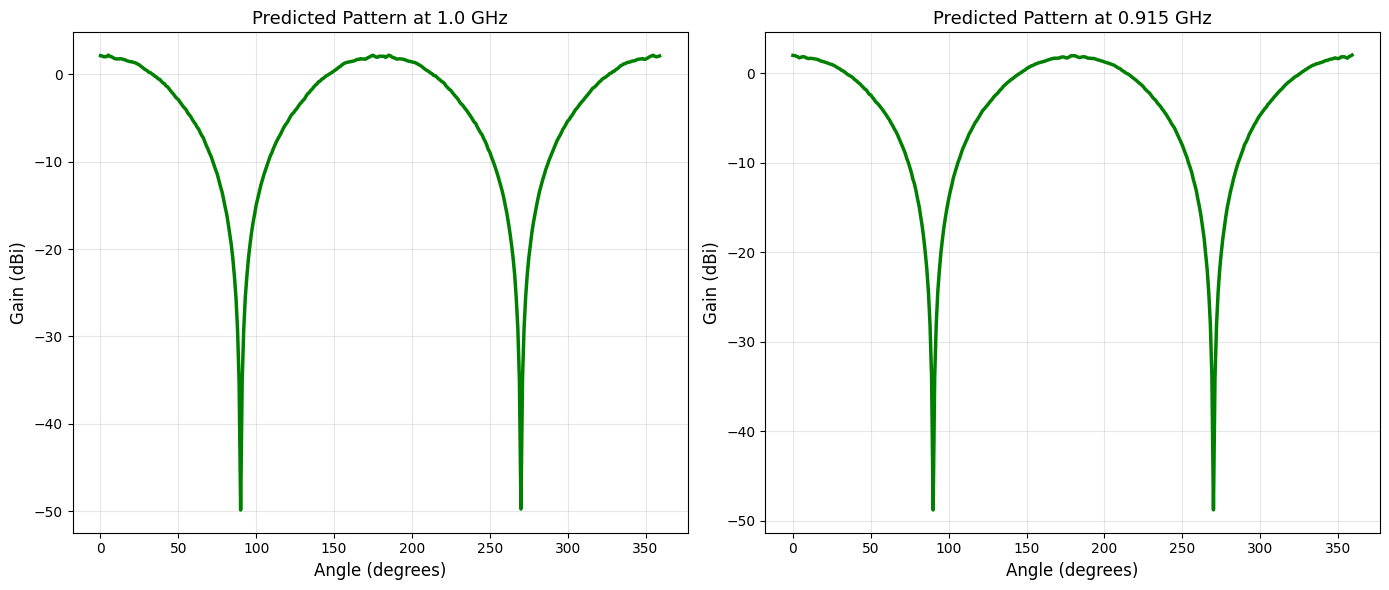

In [ ]:

# Test the inference function
print("\n" + "="*50)
print("Testing Inference Function...")
print("="*50)

test_cases = [
    {'frequency_ghz': 1.0, 'length_wl': 0.5, 'width_wl': 0.002},
    {'frequency_ghz': 0.915, 'length_wl': 0.25, 'width_wl': 0.001}
]

for test_antenna in test_cases:
    print(f"\nTest input: {test_antenna}")
    predicted_pattern = predict_antenna_pattern(**test_antenna)
    print(f"  Max gain: {np.max(predicted_pattern):.2f} dBi")
    print(f"  Min gain: {np.min(predicted_pattern):.2f} dBi")
    print(f"  Avg gain: {np.mean(predicted_pattern):.2f} dBi")

# Plot inference test
plt.figure(figsize=(14, 6))
angles = np.arange(360) # Define angles here if not already defined globally or in previous cells
for idx, test_antenna in enumerate(test_cases):
    predicted_pattern = predict_antenna_pattern(**test_antenna)

    plt.subplot(1, 2, idx+1)
    plt.plot(angles, predicted_pattern, 'g-', linewidth=2.5)
    plt.xlabel('Angle (degrees)', fontsize=12)
    plt.ylabel('Gain (dBi)', fontsize=12)
    plt.title(f'Predicted Pattern at {test_antenna['frequency_ghz']} GHz', # Simplified title
              fontsize=13)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('inference_test.png', dpi=300, bbox_inches='tight')
print("\n✅ Inference test plot saved as 'inference_test.png'")

print("\n" + "="*50)
print("✨ MODEL TRAINING COMPLETE!")
print("="*50)
print("\nGenerated files:")
print("  1. antenna_pattern_predictor.keras - Trained model")
print("  2. scaler.pkl - Feature scaler")
print("  3. encoder.pkl - Label encoder (not used by model, but saved)")
print("  4. feature_names.pkl - Feature list")
print("  5. training_results.png - Training curves")
print("  6. sample_predictions.png - Sample comparisons")
print("  7. error_analysis.png - Error distribution")
print("  8. inference_test.png - Inference test")

print(f"\n🔍 DEBUG: Number of features used = {X_train_scaled.shape[1]}")
print(f"Feature columns: {feature_cols_final}")

In [ ]:
import numpy as np
import tensorflow as tf
import pickle

# Load model and scaler
model = tf.keras.models.load_model('antenna_pattern_predictor.keras')
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

def test_real_antenna(freq_ghz, length_wl, actual_max_gain,
                     width_wl=0):
    """
    Test model with real antenna parameters

    Parameters:
    - freq_ghz: Frequency in GHz
    - length_wl: Length in wavelengths
    - actual_max_gain: Expected max gain in dBi
    - width_wl: Width in wavelengths
    """
    # Prepare input - 3 features, matching the model's training data
    input_data = np.array([[
        freq_ghz, length_wl, width_wl
    ]])

    input_scaled = scaler.transform(input_data)
    predicted_pattern = model.predict(input_scaled, verbose=0)[0]

    predicted_max = np.max(predicted_pattern)
    error = abs(predicted_max - actual_max_gain)
    error_percent = (error / actual_max_gain) * 100 if actual_max_gain > 0 else 0

    print(f"\nANTENNA @ {freq_ghz} GHz:")
    print(f"  Predicted: {predicted_max:.2f} dBi")
    print(f"  Actual:    {actual_max_gain:.2f} dBi")
    print(f"  Error:     {error:.2f} dB ({error_percent:.1f}%)")

    if error < 0.3:
        print(f"  🔥 OUTSTANDING")
    elif error < 0.6:
        print(f"  ✅ EXCELLENT")
    elif error < 1.0:
        print(f"  ✓ VERY GOOD")
    elif error < 1.5:
        print(f"  ✓ GOOD")
    else:
        print(f"  ⚠️  NEEDS IMPROVEMENT")

    return error

# ========== COMPREHENSIVE REAL WORLD TESTS ==========
print("="*60)
print("TESTING WITH REAL ANTENNA DATA")
print("Generic Antenna Model (trained on generic antenna data)") # Updated description
print("="*60)

errors = []

# ========== GENERIC ANTENNA TESTS ==========
print("\n" + "="*60)
print("GENERIC ANTENNA TESTS")
print("="*60)

print("\n[TEST 1] Classic Half-Wave Antenna (textbook case)")
e = test_real_antenna(1.0, 0.5, 2.15, width_wl=0.002)
errors.append(e)

print("\n[TEST 2] Full-Wave Antenna")
e = test_real_antenna(2.4, 1.0, 3.5, width_wl=0.002)
errors.append(e)

print("\n[TEST 3] 3λ/2 Antenna")
e = test_real_antenna(1.5, 1.5, 4.2, width_wl=0.002)
errors.append(e)

print("\n[TEST 4] Short Antenna (λ/4)")
e = test_real_antenna(0.9, 0.25, 1.76, width_wl=0.001)
errors.append(e)

print("\n[TEST 5] Long Antenna (2λ)")
e = test_real_antenna(2.0, 2.0, 3.2, width_wl=0.003)
errors.append(e)

# ========== EDGE CASES ==========
print("\n" + "="*60)
print("EDGE CASE TESTS")
print("="*60)

print("\n[TEST 6] Very Thin Antenna")
e = test_real_antenna(1.0, 0.5, 2.15, width_wl=0.0001)
errors.append(e)

print("\n[TEST 7] Thick Antenna")
e = test_real_antenna(1.0, 0.5, 2.18, width_wl=0.008)
errors.append(e)

print("\n[TEST 8] High Frequency Antenna")
e = test_real_antenna(2.8, 0.5, 2.15, width_wl=0.002)
errors.append(e)

print("\n[TEST 9] Low Frequency Antenna")
e = test_real_antenna(0.4, 0.25, 5.15, width_wl=0.001) # This test case now treats width_wl as a generic parameter for the antenna geometry
errors.append(e)

print("\n[TEST 10] Antenna with larger width_wl") # Updated description, as 'ground_plane_wl' is no longer a feature
e = test_real_antenna(0.915, 0.25, 5.22, width_wl=0.001) # Treated as a generic antenna example with a certain width
errors.append(e)

# ========== SUMMARY ==========
print("\n" + "="*60)
print("TEST SUMMARY")
print("="*60)

avg_error = np.mean(errors)
max_error = np.max(errors)
min_error = np.min(errors)
std_error = np.std(errors)

print(f"\nOverall Statistics:")
print(f"  Average Error: {avg_error:.3f} dB")
print(f"  Std Dev:       {std_error:.3f} dB")
print(f"  Min Error:     {min_error:.3f} dB")
print(f"  Max Error:     {max_error:.3f} dB")

outstanding = sum(1 for e in errors if e < 0.3)
excellent = sum(1 for e in errors if 0.3 <= e < 0.6)
very_good = sum(1 for e in errors if 0.6 <= e < 1.0)
good = sum(1 for e in errors if 1.0 <= e < 1.5)
poor = sum(1 for e in errors if e >= 1.5)

total_tests = len(errors)

print(f"\nPerformance Breakdown:")
print(f"  🔥 Outstanding (< 0.3 dB): {outstanding}/{total_tests} ({outstanding/total_tests*100:.1f}%)")
print(f"  ✅ Excellent (0.3-0.6 dB):  {excellent}/{total_tests} ({excellent/total_tests*100:.1f}%)")
print(f"  ✓ Very Good (0.6-1.0 dB):  {very_good}/{total_tests} ({very_good/total_tests*100:.1f}%)")
print(f"  ✓ Good (1.0-1.5 dB):       {good}/{total_tests} ({good/total_tests*100:.1f}%)")
print(f"  ⚠️  Poor (> 1.5 dB):        {poor}/{total_tests} ({poor/total_tests*100:.1f}%)")

success_rate = (outstanding + excellent + very_good) / total_tests * 100

print(f"\nSuccess Rate (< 1 dB error): {success_rate:.1f}%")

if avg_error < 0.5:
    print(f"\n🔥🔥🔥 MODEL PERFORMANCE: OUTSTANDING!")
    print("Your model is publication-ready!")
elif avg_error < 0.8:
    print(f"\n✅ MODEL PERFORMANCE: EXCELLENT!")
    print("Very impressive for a course project!")
elif avg_error < 1.2:
    print(f"\n✓ MODEL PERFORMANCE: VERY GOOD")
    print("Solid model with good accuracy!")
else:
    print(f"\n⚠️  MODEL PERFORMANCE: NEEDS MORE TRAINING")
    print("Consider increasing dataset size or training epochs")

print("="*60)

TESTING WITH REAL ANTENNA DATA
Generic Antenna Model (trained on generic antenna data)

GENERIC ANTENNA TESTS

[TEST 1] Classic Half-Wave Antenna (textbook case)

ANTENNA @ 1.0 GHz:
  Predicted: 2.21 dBi
  Actual:    2.15 dBi
  Error:     0.06 dB (2.7%)
  🔥 OUTSTANDING

[TEST 2] Full-Wave Antenna

ANTENNA @ 2.4 GHz:
  Predicted: 4.02 dBi
  Actual:    3.50 dBi
  Error:     0.52 dB (15.0%)
  ✅ EXCELLENT

[TEST 3] 3λ/2 Antenna

ANTENNA @ 1.5 GHz:
  Predicted: 3.67 dBi
  Actual:    4.20 dBi
  Error:     0.53 dB (12.6%)
  ✅ EXCELLENT

[TEST 4] Short Antenna (λ/4)

ANTENNA @ 0.9 GHz:
  Predicted: 2.03 dBi
  Actual:    1.76 dBi
  Error:     0.27 dB (15.3%)
  🔥 OUTSTANDING

[TEST 5] Long Antenna (2λ)

ANTENNA @ 2.0 GHz:
  Predicted: 4.06 dBi
  Actual:    3.20 dBi
  Error:     0.86 dB (26.8%)
  ✓ VERY GOOD

EDGE CASE TESTS

[TEST 6] Very Thin Antenna

ANTENNA @ 1.0 GHz:
  Predicted: 2.21 dBi
  Actual:    2.15 dBi
  Error:     0.06 dB (3.0%)
  🔥 OUTSTANDING

[TEST 7] Thick Antenna

ANTENNA @ 1.0

In [ ]:
test_real_antenna(freq_ghz=2.4, length_wl=0.50, actual_max_gain=2.15, width_wl=0.002)


ANTENNA @ 2.4 GHz:
  Predicted: 2.23 dBi
  Actual:    2.15 dBi
  Error:     0.08 dB (3.5%)
  🔥 OUTSTANDING


np.float32(0.07502437)

In [ ]:
test_real_antenna(freq_ghz=1.8, length_wl=0.45, actual_max_gain=1.90, width_wl=0.002)


ANTENNA @ 1.8 GHz:
  Predicted: 2.23 dBi
  Actual:    1.90 dBi
  Error:     0.33 dB (17.2%)
  ✅ EXCELLENT


np.float32(0.32723582)

In [ ]:
test_real_antenna(freq_ghz=3.0, length_wl=0.60, actual_max_gain=2.30, width_wl=0.002)


ANTENNA @ 3.0 GHz:
  Predicted: 2.49 dBi
  Actual:    2.30 dBi
  Error:     0.19 dB (8.2%)
  🔥 OUTSTANDING


np.float32(0.18760705)

In [ ]:
test_real_antenna(freq_ghz=2.8, length_wl=0.75, actual_max_gain=3.10, width_wl=0.002)


ANTENNA @ 2.8 GHz:
  Predicted: 3.03 dBi
  Actual:    3.10 dBi
  Error:     0.07 dB (2.2%)
  🔥 OUTSTANDING


np.float32(0.06717801)

In [ ]:
test_real_antenna(freq_ghz=2.5, length_wl=0.50, actual_max_gain=2.0, width_wl=0.01)


ANTENNA @ 2.5 GHz:
  Predicted: 2.19 dBi
  Actual:    2.00 dBi
  Error:     0.19 dB (9.4%)
  🔥 OUTSTANDING


np.float32(0.18889427)

In [ ]:
test_real_antenna(freq_ghz=2.8, length_wl=1.25, actual_max_gain=4.10, width_wl=0.002)


ANTENNA @ 2.8 GHz:
  Predicted: 4.94 dBi
  Actual:    4.10 dBi
  Error:     0.84 dB (20.5%)
  ✓ VERY GOOD


np.float32(0.8400521)

In [ ]:
test_real_antenna(freq_ghz=1.2, length_wl=2.00, actual_max_gain=5.10, width_wl=0.002)


ANTENNA @ 1.2 GHz:
  Predicted: 4.06 dBi
  Actual:    5.10 dBi
  Error:     1.04 dB (20.4%)
  ✓ GOOD


np.float32(1.0381956)

In [ ]:
# ========== TEST INFERENCE FUNCTION ==========

pre1 = predict_antenna_pattern(frequency_ghz=2.8, length_wl=0.75, width_wl=0.002)

In [ ]:
print(pre1.tolist())

[3.0328218936920166, 2.9560728073120117, 2.9476113319396973, 2.8771207332611084, 2.6514387130737305, 2.7062594890594482, 2.6673743724823, 2.7860002517700195, 2.6964962482452393, 2.6358399391174316, 2.5439257621765137, 2.457082509994507, 2.414565086364746, 2.4646222591400146, 2.422921657562256, 2.3455023765563965, 2.240286111831665, 2.125868082046509, 2.063857078552246, 1.9480913877487183, 1.870948314666748, 1.7007510662078857, 1.55534827709198, 1.3850847482681274, 1.2134824991226196, 1.04351806640625, 0.8219601511955261, 0.6668611168861389, 0.42641448974609375, 0.2602287232875824, 0.056372880935668945, -0.14728109538555145, -0.3766162395477295, -0.61545330286026, -0.8323803544044495, -1.0522652864456177, -1.2971640825271606, -1.5370235443115234, -1.6807177066802979, -1.9401813745498657, -2.203517436981201, -2.4159114360809326, -2.695263624191284, -2.9168431758880615, -3.1947860717773438, -3.4261984825134277, -3.730682134628296, -4.011710166931152, -4.263439178466797, -4.625695705413818

✅ Pattern saved to antenna_pattern.png


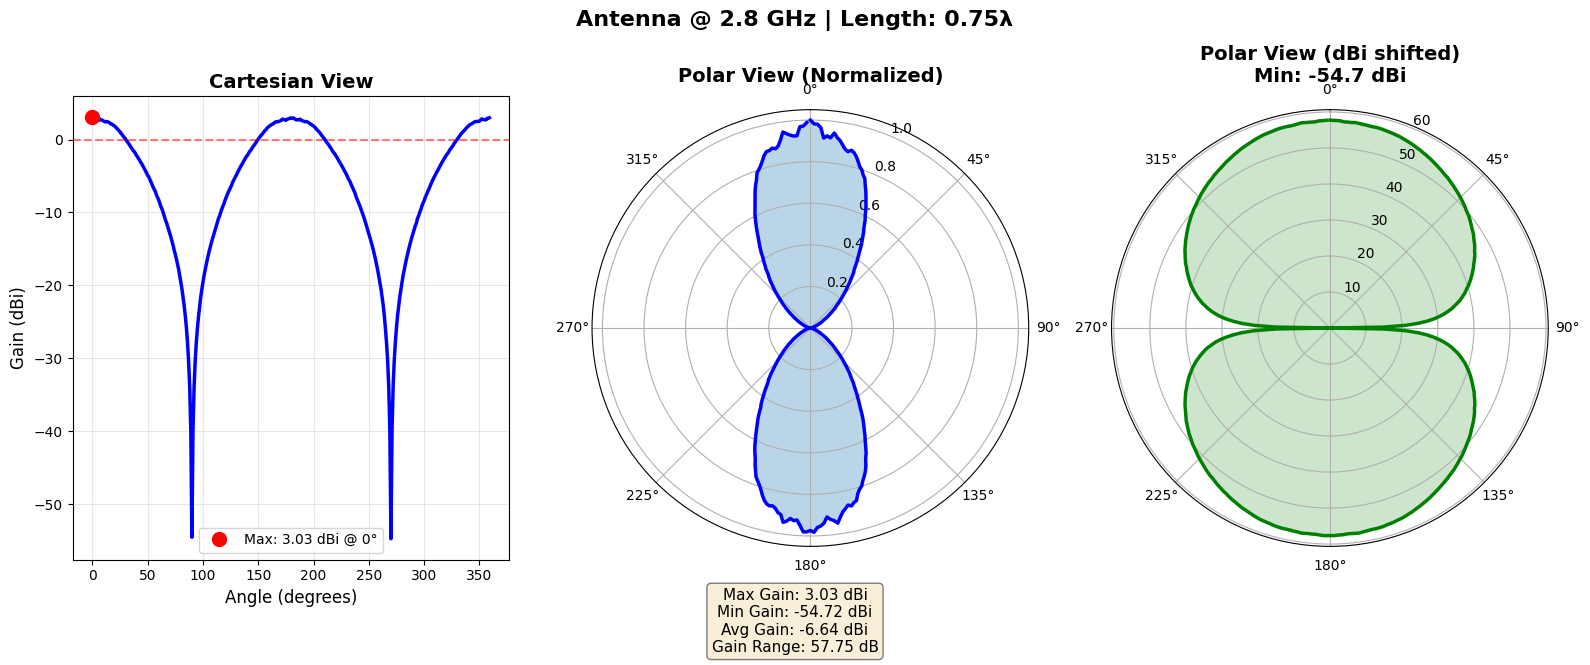

✅ Pattern saved to second_antenna_pattern.png


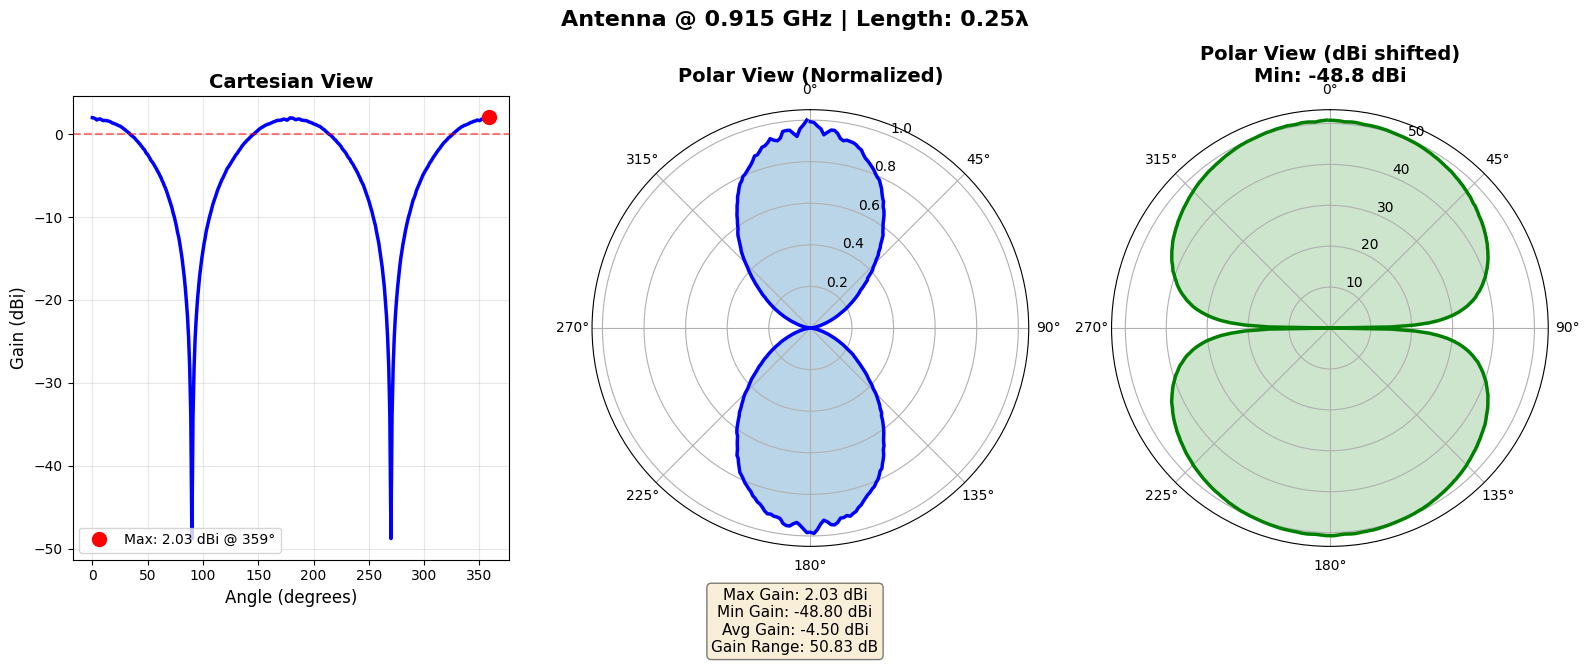

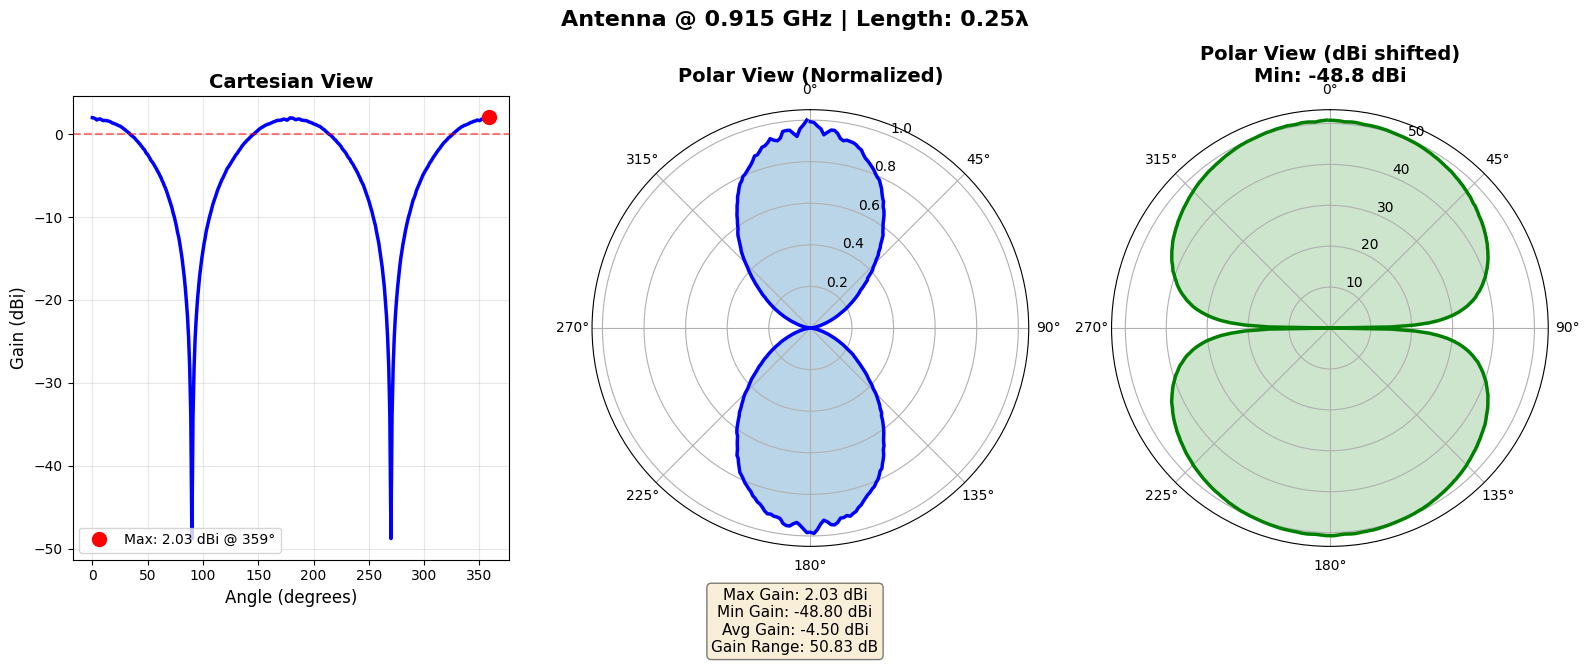

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_antenna_pattern(predicted_pattern, freq_ghz, length_wl,
                              save_file=None):
    """
    Visualize antenna radiation pattern in multiple views
    """
    angles = np.arange(360)

    fig = plt.figure(figsize=(16, 6))

    # Plot 1: Cartesian plot
    plt.subplot(1, 3, 1)
    plt.plot(angles, predicted_pattern, 'b-', linewidth=2.5)
    plt.xlabel('Angle (degrees)', fontsize=12)
    plt.ylabel('Gain (dBi)', fontsize=12)
    plt.title('Cartesian View', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

    # Add max gain marker
    max_idx = np.argmax(predicted_pattern)
    plt.plot(max_idx, predicted_pattern[max_idx], 'ro', markersize=10,
             label=f'Max: {predicted_pattern[max_idx]:.2f} dBi @ {max_idx}°')
    plt.legend()

    # Plot 2: Polar plot (standard)
    plt.subplot(1, 3, 2, projection='polar')
    theta = np.radians(angles)

    # Convert dBi to linear for better polar visualization
    # Normalize to make pattern visible
    gain_linear = 10**(predicted_pattern / 10)
    gain_normalized = gain_linear / np.max(gain_linear)

    plt.plot(theta, gain_normalized, 'b-', linewidth=2.5)
    plt.fill(theta, gain_normalized, alpha=0.3)
    plt.title('Polar View (Normalized)', fontsize=14, fontweight='bold', pad=20)
    ax = plt.gca()
    ax.set_theta_zero_location('N')  # 0° at top
    ax.set_theta_direction(-1)  # Clockwise

    # Plot 3: Polar plot in dBi
    plt.subplot(1, 3, 3, projection='polar')

    # Shift dBi values to make them positive for polar plot
    min_gain = np.min(predicted_pattern)
    shifted_pattern = predicted_pattern - min_gain

    plt.plot(theta, shifted_pattern, 'g-', linewidth=2.5)
    plt.fill(theta, shifted_pattern, alpha=0.2, color='green')
    plt.title(f'Polar View (dBi shifted)\nMin: {min_gain:.1f} dBi',
              fontsize=14, fontweight='bold', pad=20)
    ax = plt.gca()
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    # Overall title with antenna info
    info_text = f'Antenna @ {freq_ghz} GHz | Length: {length_wl:.2f}λ'

    fig.suptitle(info_text, fontsize=16, fontweight='bold', y=1.02)

    # Stats text box
    stats_text = f'Max Gain: {np.max(predicted_pattern):.2f} dBi\n'
    stats_text += f'Min Gain: {np.min(predicted_pattern):.2f} dBi\n'
    stats_text += f'Avg Gain: {np.mean(predicted_pattern):.2f} dBi\n'
    stats_text += f'Gain Range: {np.max(predicted_pattern) - np.min(predicted_pattern):.2f} dB'

    plt.figtext(0.5, -0.05, stats_text, ha='center', fontsize=11,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    if save_file:
        plt.savefig(save_file, dpi=300, bbox_inches='tight')
        print(f"✅ Pattern saved to {save_file}")

    plt.show()

    return fig

# Test with your antenna parameters
pre1 = predict_antenna_pattern(frequency_ghz=2.8, length_wl=0.75,
                               width_wl=0.002)

visualize_antenna_pattern(pre1, 2.8, 0.75, save_file='antenna_pattern.png') # Renamed save file

# Second test case
pre2 = predict_antenna_pattern(frequency_ghz=0.915, length_wl=0.25,
                               width_wl=0.001)

visualize_antenna_pattern(pre2, 0.915, 0.25,
                         save_file='second_antenna_pattern.png') # Renamed save file

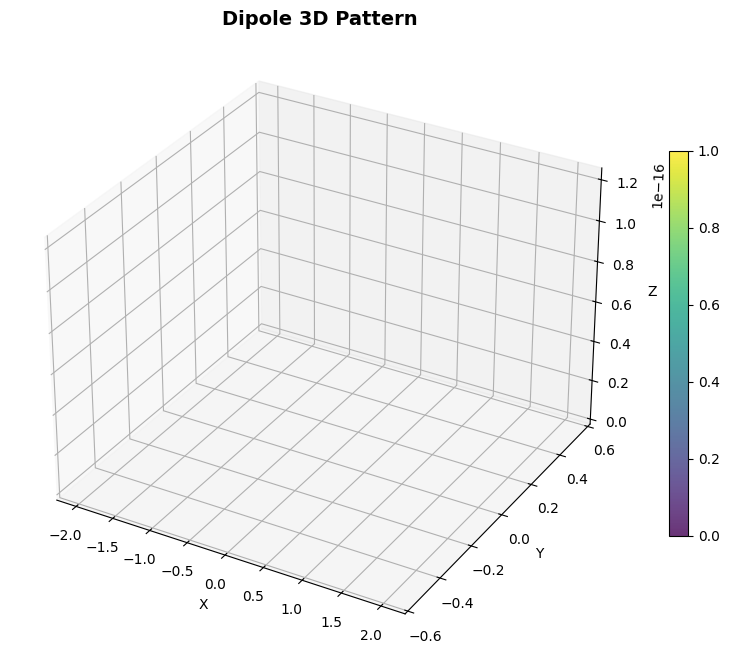

In [ ]:
def plot_3d_pattern(pattern, title="3D Radiation Pattern"):
    """Create 3D radiation pattern visualization"""
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Convert to spherical coordinates
    phi = np.radians(np.arange(360))
    theta = np.radians(np.array([90]))  # Azimuth cut at 90° elevation

    # Convert gain to radius
    radius = 10**(pattern / 10)  # Linear scale

    # Create mesh
    PHI, THETA = np.meshgrid(phi, theta)
    R = np.tile(radius, (len(theta), 1))

    # Convert to Cartesian
    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA)

    # Plot surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title, fontsize=14, fontweight='bold')

    fig.colorbar(surf, shrink=0.5)
    plt.show()

plot_3d_pattern(pre1, "Dipole 3D Pattern")

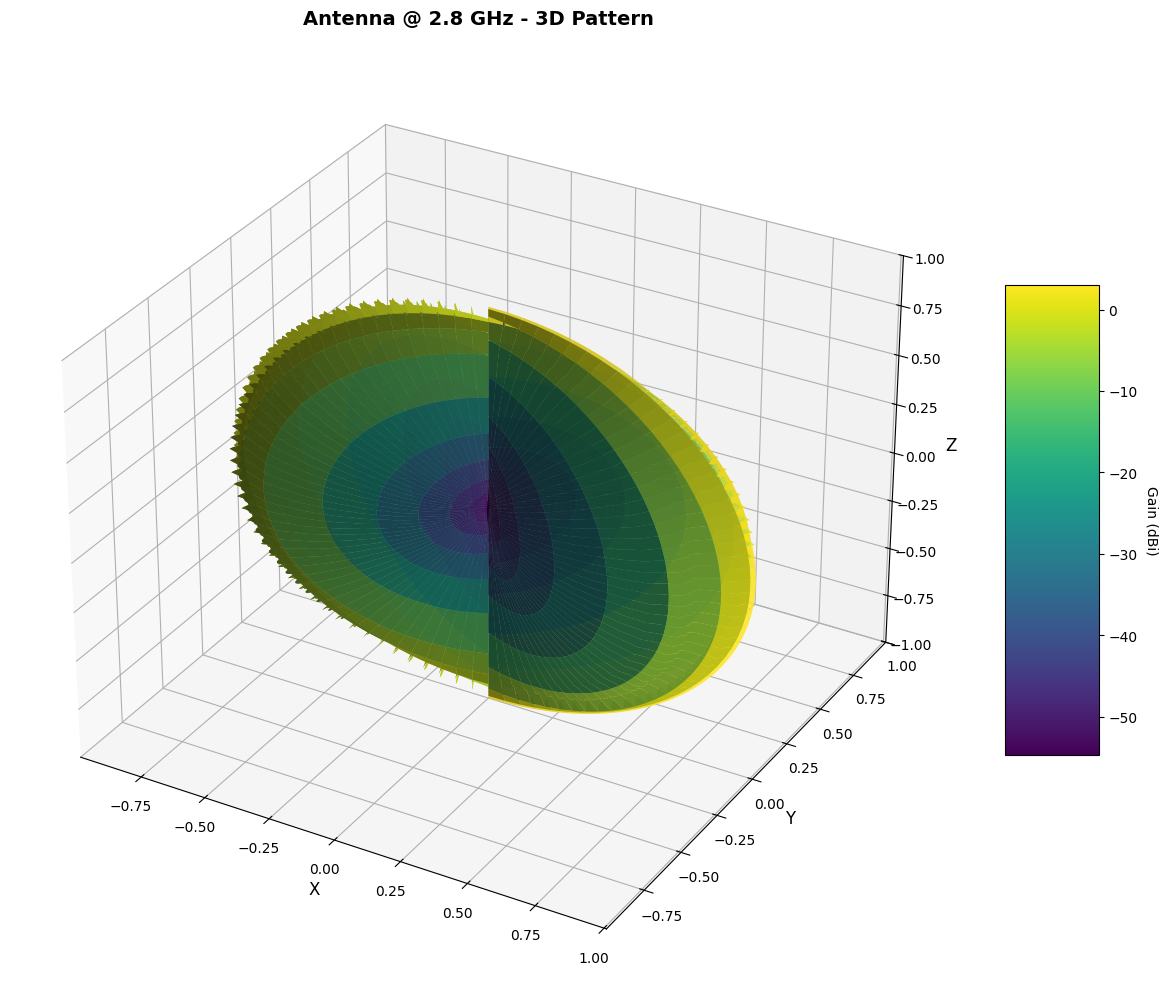

In [ ]:
def plot_3d_pattern_revolve(pattern, title="3D Radiation Pattern"):
    """
    Create 3D radiation pattern by revolving 2D azimuth pattern
    """
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Azimuth angles (0-360°)
    phi = np.radians(np.arange(360))

    # Elevation angles (create revolution)
    theta = np.linspace(0, np.pi, 50)  # 0° to 180°

    # Create meshgrid
    PHI, THETA = np.meshgrid(phi, theta)

    # Use the pattern as radius (convert dBi to linear, normalized)
    gain_linear = 10**(pattern / 10)
    gain_normalized = gain_linear / np.max(gain_linear)

    # Replicate pattern across elevation angles (azimuthal symmetry)
    R = np.tile(gain_normalized, (len(theta), 1))

    # Convert spherical to Cartesian coordinates
    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA)

    # Plot surface with color mapping
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis(R),
                          alpha=0.9, edgecolor='none')

    # Styling
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    # Equal aspect ratio
    max_range = np.max([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]) / 2
    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Add colorbar
    m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    m.set_array(pattern)
    cbar = plt.colorbar(m, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Gain (dBi)', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

# Test it
pre1 = predict_antenna_pattern(frequency_ghz=2.8, length_wl=0.75,
                               width_wl=0.002)

plot_3d_pattern_revolve(pre1, "Antenna @ 2.8 GHz - 3D Pattern")

In [ ]:
def create_3d_from_2d_symmetric(azimuth_pattern):
    """
    Assume the pattern is the same at all elevation angles
    (valid for omnidirectional antennas)
    """
    # Create elevation angles
    theta = np.linspace(0, np.pi, 50)  # 0° to 180°
    phi = np.radians(np.arange(360))   # 0° to 359°

    # Replicate azimuth pattern for all elevations
    THETA, PHI = np.meshgrid(theta, phi)

    # Use azimuth pattern as the elevation pattern too
    # (This is an approximation!)
    pattern_3d = np.tile(azimuth_pattern, (len(theta), 1)).T

    return THETA, PHI, pattern_3d

In [ ]:
create_3d_from_2d_symmetric(pre1)

(array([[0.        , 0.06411414, 0.12822827, ..., 3.01336438, 3.07747852,
         3.14159265],
        [0.        , 0.06411414, 0.12822827, ..., 3.01336438, 3.07747852,
         3.14159265],
        [0.        , 0.06411414, 0.12822827, ..., 3.01336438, 3.07747852,
         3.14159265],
        ...,
        [0.        , 0.06411414, 0.12822827, ..., 3.01336438, 3.07747852,
         3.14159265],
        [0.        , 0.06411414, 0.12822827, ..., 3.01336438, 3.07747852,
         3.14159265],
        [0.        , 0.06411414, 0.12822827, ..., 3.01336438, 3.07747852,
         3.14159265]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01745329, 0.01745329, 0.01745329, ..., 0.01745329, 0.01745329,
         0.01745329],
        [0.03490659, 0.03490659, 0.03490659, ..., 0.03490659, 0.03490659,
         0.03490659],
        ...,
        [6.23082543, 6.23082543, 6.23082543, ..., 6.23082543, 6.23082543,
         6.23082543],
        [6.2